In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import sys
sys.path.append("..")
#import os
from utils.model3 import Net_mask
#from utils.data import Data
#from utils.loss_experiment import Loss
#from scripts.parameters import get_parameters
import torch
#import numpy as np
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal

In [33]:
tensor_D = torch.tensor(
    [[1, -1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, -1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0,  1, -1, 0, 0, 0, 0, 0, 0],
    [0, 0,  0, 1, -1, 0, 0, 0, 0, 0],
    [0, 0,  0, 0, 1, -1, 0, 0, 0, 0],
    [0, 0,  0, 0, 0, 1, -1, 0, 0, 0],
    [0, 0,  0, 0, 0, 0, 1, -1, 0, 0],
    [0, 0,  0, 0, 0, 0, 0, 1, -1, 0],
    [0, 0,  0, 0, 0, 0, 0, 0, 1, -1],
    [-1, 0, 0, 0, 0, 0, 0, 0, 0, 1],], dtype=torch.float
)
tensor_Q_m  = torch.mm(torch.t(tensor_D), tensor_D)
n_param = tensor_D.size(dim=0)
tau2 = 1000 # 1/tau2 is the noise added to the diagonal
tensor_Q_m_modified = tensor_Q_m + torch.eye(n_param)*(1./tau2)
sigma2_eps = 0.01  # 1/sigma2_eps is the factor before the likelihood
tensor_mu_m = torch.zeros(n_param)

tensor_Sigma_m = torch.inverse(tensor_Q_m_modified)
tensor_Sigma_eps = torch.eye(n_param)*sigma2_eps
tensor_mu_eps = tensor_mu_m 

In [34]:
def loss(tensor_input, tensor_output):
    tensor_Psi = tensor_output
    tensor_Gd = tensor_input[:,:n_param]
    tensor_mask = tensor_input[:,n_param:]
    tensor_GPsi = tensor_Psi*tensor_mask

    # data residual loss
    tensor_squared_error = torch.square(tensor_GPsi - tensor_Gd)
    tensor_squared_error_sum = torch.sum(tensor_squared_error, [0, 1])
    tensor_data_fit_loss = tensor_squared_error_sum

    # data regularization loss
    tensor_PsiQ_m = torch.matmul(tensor_Psi, tensor_Q_m)
    tensor_PsiQ_m = torch.unsqueeze(tensor_PsiQ_m, 1)
    tensor_Psi = torch.unsqueeze(tensor_Psi, 2)
    tensor_PsiQ_mPsi = torch.bmm(tensor_PsiQ_m, tensor_Psi).squeeze(2)
    tensor_data_regularization_loss = torch.sum(tensor_PsiQ_mPsi)

In [35]:
n_data = 1000
n_points = 6
all_test_obses = torch.zeros(n_points, n_data, 2*n_param)
all_test_obses
all_test_obses[0,:,:].shape

torch.Size([1000, 20])

In [36]:
for i in range(n_points):
    data_cov = 1
    data_mean = torch.zeros(n_param)
    data_covariance = torch.eye(n_param)*data_cov

    torch.manual_seed(4195+i)
    tensor_data = torch.zeros(n_data, 2*n_param)
    tensor_d_sample =  MultivariateNormal(loc=data_mean, covariance_matrix=data_covariance).sample(sample_shape=(n_data,))
    #tensor_n_masked = torch.randint(n_param, (n_data,))
    tensor_n_masked = torch.Tensor([i+1])
    tensor_masks = torch.rand(n_data, n_param).argsort(dim=1)
    tensor_masks = (tensor_masks < tensor_n_masked.unsqueeze(1))*1
    tensor_data[:,:n_param] = tensor_d_sample*tensor_masks
    tensor_data[:,n_param:] = tensor_masks
    all_test_obses[i,:,:] = tensor_data
torch.save(all_test_obses, f'../data/test_observations/test_set_full/all_test_obses.pt')

In [37]:
all_test_obses[5,15]

tensor([-0.0000, -1.0753, -1.3035,  0.7447, -0.8766,  0.9149, -0.0000,  0.0000,
         0.0000, -2.1578,  0.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         0.0000,  0.0000,  0.0000,  1.0000])

In [38]:
n_data = 1000
n_points = 6
all_test_solutions = torch.zeros(n_points, n_data, n_param)

for j in range(6):
    for i in range(1000):
        #print(j, i)
        input_tensor = all_test_obses[j,i,:]
        d = input_tensor[:n_param]
        mask = input_tensor[n_param:]
        location = torch.where(mask > 0.5)
        d = d[location]
        n_data = len(d)
        G = torch.zeros(n_data, n_param)
        for idx, elem in enumerate(location[0]):
            G[idx, elem] = 1
        Sigma_eps = torch.matmul(G, torch.matmul(tensor_Sigma_eps, torch.t(G)))
        mu_eps = torch.matmul(G, tensor_mu_eps)

        #matrix calculations
        Sigma_mm = tensor_Sigma_m
        Sigma_dm = torch.matmul(G,Sigma_mm)
        Sigma_md = torch.matmul(Sigma_mm, torch.t(G))
        Sigma_dd = torch.matmul(G, torch.matmul(Sigma_mm, torch.t(G))) + Sigma_eps
        Sigma_dd_inv = torch.inverse(Sigma_dd)
        mu_m_d = tensor_mu_m + torch.matmul(torch.matmul(Sigma_md, Sigma_dd_inv),(d-mu_eps))
        Sigma_m_d = Sigma_mm - torch.matmul(torch.matmul(Sigma_md, Sigma_dd_inv), Sigma_dm)
        all_test_solutions[j,i,:] = mu_m_d
        print(j, i)
torch.save(all_test_solutions, f'../data/test_observations/test_set_full/all_test_solutions.pt')

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
0 100
0 101
0 102
0 103
0 104
0 105
0 106
0 107
0 108
0 109
0 110
0 111
0 112
0 113
0 114
0 115
0 116
0 117
0 118
0 119
0 120
0 121
0 122
0 123
0 124
0 125
0 126
0 127
0 128
0 129
0 130
0 131
0 132
0 133
0 134
0 135
0 136
0 137
0 138
0 139
0 140
0 141
0 142
0 143
0 144
0 145
0 146
0 147
0 148
0 149
0 150
0 151
0 152
0 153
0 154
0 155
0 156
0 157
0 158
0 159
0 160
0 161
0 162
0 163
0 164
0 165
0 166
0 167
0 168
0 169
0 170
0 171
0 172
0 173
0 174
0 175
0 176
0 177
0 178
0 179
0 180
0 181
0 182
0 183
0 184


In [39]:
all_test_solutions[5,:10]

tensor([[-0.6218,  0.8464,  1.4956, -0.1925, -0.0575,  0.0786,  0.2137,  0.3495,
          1.4475,  0.4129],
        [ 0.7885,  0.4756,  0.1623,  1.4218,  2.2647,  1.3683,  0.4720, -0.5602,
          0.2708,  1.1019],
        [ 0.0553,  0.6305, -1.6796, -0.1814,  0.3757, -0.7963, -0.8956, -0.9957,
         -1.0954, -0.5201],
        [ 0.7479,  0.8397,  0.9623,  2.7195,  0.5388,  0.3758,  0.3799,  0.4718,
          0.5638,  0.6559],
        [-0.2628,  1.1918,  0.2785,  0.4146,  0.5503,  0.6863,  0.8226, -0.6119,
          0.0943, -0.0843],
        [ 1.2232,  0.3011, -0.6208,  0.8645, -0.1675, -0.2003, -0.2334, -0.2665,
         -0.2997,  0.9353],
        [-0.5422, -0.5154, -0.4884, -0.2466, -0.6393, -1.0324,  0.5727,  1.1099,
          0.5590,  0.0084],
        [-1.1700, -2.2983, -1.0219,  0.2542,  0.8907,  1.2042,  1.2046,  1.2067,
          1.2086,  0.0196],
        [-0.6624, -0.5623, -0.4625, -0.0436,  0.3757,  1.1171,  0.5130, -1.4537,
         -0.8628, -0.7627],
        [-0.1030, -

In [40]:
all_test_solutions[1,2,:]

tensor([0.4060, 0.4602, 0.5147, 0.5691, 0.0806, 0.1348, 0.1889, 0.2432, 0.2973,
        0.3517])

In [41]:
all_test_solutions[1,:6,:]

tensor([[ 0.1522,  0.3450,  0.2623,  0.1797,  0.0971,  0.0144, -0.0681, -0.1508,
         -0.2334, -0.0406],
        [-0.1189,  0.1388,  0.3966,  0.6545,  0.9124,  1.1704,  1.4284,  0.8267,
          0.2250, -0.3767],
        [ 0.4060,  0.4602,  0.5147,  0.5691,  0.0806,  0.1348,  0.1889,  0.2432,
          0.2973,  0.3517],
        [-1.2608, -0.7739, -0.2873,  0.1994,  0.6860,  0.3616,  0.0372, -0.2872,
         -0.6115, -0.9360],
        [-1.0885, -1.1320, -1.0670, -1.0019, -0.9371, -0.8723, -0.9154, -0.9585,
         -1.0017, -1.0450],
        [ 0.0550,  0.5896,  1.1241,  1.6588,  1.3023,  0.9457,  0.5894,  0.2331,
         -0.1232, -0.4794]])

tensor([-0.0000,  0.6521, -0.1757,  0.2288, -0.3110,  0.0000, -0.0499,  0.0000,
        -0.0000, -0.0000,  0.0000,  1.0000,  1.0000,  1.0000,  1.0000,  0.0000,
         1.0000,  0.0000,  0.0000,  0.0000])
tensor([-0.0000,  0.6521, -0.1757,  0.2288, -0.3110,  0.0000, -0.0499,  0.0000,
        -0.0000, -0.0000,  0.0000,  1.0000,  1.0000,  1.0000,  1.0000,  0.0000,
         1.0000,  0.0000,  0.0000,  0.0000])
tensor([0., 1., 1., 1., 1., 0., 1., 0., 0., 0.])
(tensor([1, 2, 3, 4, 6]),)


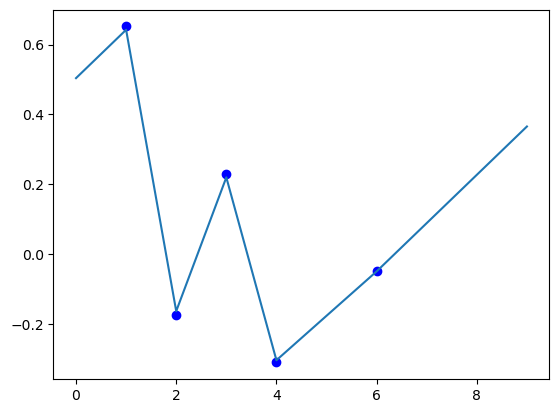

In [42]:
n_points = 4
ind = 50
data = all_test_obses[n_points,ind,:]
print(data)
input_tensor = data 
print(input_tensor)
mask = input_tensor[10:]
print(mask)
location_raw = torch.where(mask > 0.5)
print(location_raw)
location = location_raw[0]
#print(location)
points = input_tensor[location_raw]
#print(points)

#print(all_test_solutions)

plt.plot(location, points, 'bo')
plt.plot(range(10), all_test_solutions[n_points,ind,:])

tensor([-0.0000,  0.6521, -0.1757,  0.2288, -0.3110,  0.0000, -0.0499,  0.0000,
        -0.0000, -0.0000,  0.0000,  1.0000,  1.0000,  1.0000,  1.0000,  0.0000,
         1.0000,  0.0000,  0.0000,  0.0000])
tensor([-0.0000,  0.6521, -0.1757,  0.2288, -0.3110,  0.0000, -0.0499,  0.0000,
        -0.0000, -0.0000,  0.0000,  1.0000,  1.0000,  1.0000,  1.0000,  0.0000,
         1.0000,  0.0000,  0.0000,  0.0000])
mask:  tensor([0., 1., 1., 1., 1., 0., 1., 0., 0., 0.])
(tensor([1, 2, 3, 4, 6]),)
tensor([1, 2, 3, 4, 6])
tensor([ 0.6521, -0.1757,  0.2288, -0.3110, -0.0499])
tensor([[[-0.3268, -0.3269, -0.3268,  ..., -0.3266, -0.3266, -0.3267],
         [-0.8175, -0.8172, -0.8169,  ..., -0.8167, -0.8169, -0.8172],
         [-1.0003, -1.0003, -1.0005,  ..., -1.0007, -1.0005, -1.0003],
         ...,
         [ 0.3401,  0.3399,  0.3398,  ...,  0.3397,  0.3398,  0.3399],
         [ 0.0135,  0.0136,  0.0136,  ...,  0.0135,  0.0135,  0.0135],
         [ 0.3438,  0.3438,  0.3439,  ...,  0.3438,  0.3438,

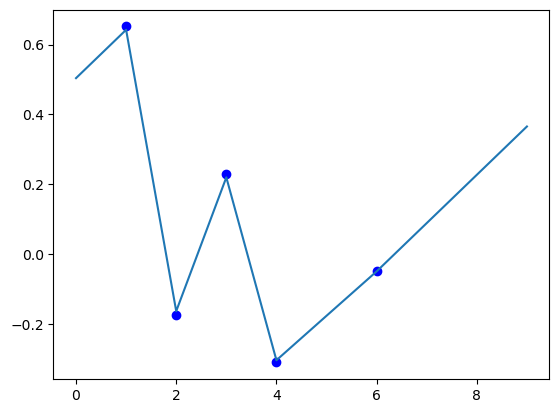

In [43]:
n_points = 4
ind = 50
data = torch.load(f'../data/test_observations/test_set_full/all_test_obses.pt')[n_points,ind,:]
all_test_solutions_ = torch.load(f'../data/test_observations/test_set_full/all_test_solutions.pt')
print(data)
input_tensor = data 
print(input_tensor)
mask = input_tensor[10:]
print('mask: ', mask)
location_raw = torch.where(mask > 0.5)
print(location_raw)
location = location_raw[0]
print(location)
points = input_tensor[location_raw]
print(points)

print(all_test_solutions)

plt.plot(location, points, 'bo')
plt.plot(range(10), all_test_solutions_[n_points,ind,:])

In [44]:
n = 5
for j in range(n):
    if j < 3:
        print(j)

0
1
2


In [45]:
j

4